In [48]:
#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import scipy
import random
import os
import pickle

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner
from cmcrameri import cm

from scripts import prior_funcs, utils

from functools import partial

# plt.style.use('dark_background')
plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

# tinygp
import tinygp
from tinygp import GaussianProcess
from tinygp import kernels
import jax

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk

jax.config.update("jax_enable_x64", True)

In [42]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = (
    ["radius", "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
    + ["nu_max"]
)

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,2.370506e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,1.156533e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.317504e+02,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,1.444480e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,2.352665e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,3.185873e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,5.856447e+03,7.993034e+03


In [43]:
a_vals = np.random.uniform(-10,2,len(df))
b_vals = np.random.uniform(4.4,5.25,len(df))

gp_df = df[[f"nu_0_{i}" for i in range(6, 41)] + ["nu_max"]]

gp_df.insert(len(gp_df.columns), 'a',a_vals)
gp_df.insert(len(gp_df.columns), 'b',b_vals)

def surf_corr(freqs, nu_max, a, b):
    return freqs + a * ((freqs / nu_max) ** b)

freq_cols = [f"nu_0_{i}" for i in range(6, 41)]


corr_array = surf_corr(gp_df[freq_cols].values, gp_df['nu_max'].values[:, np.newaxis] , gp_df['a'].values[:, np.newaxis] , gp_df['b'].values[:, np.newaxis])
corr_df = pd.DataFrame(corr_array, columns=[f"nu_0_{i}_corr" for i in range(6, 41)])

(1300.0, 4200.0)

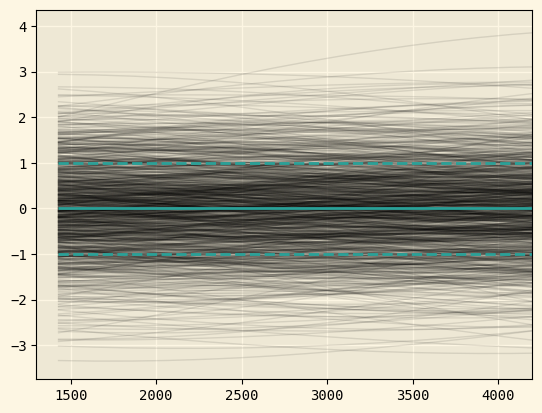

In [258]:
# Simulate a made up dataset, as an example
X = corr_df[[f"nu_0_{i}_corr" for i in range(6, 41)]].iloc[0].values.flatten()

#X = np.linspace(X.min(), X.max(), 1000)

# Compute the log probability
kernel = 1*kernels.ExpSquared(scale=20*np.mean(X[1:]-X[:-1]))
gp = GaussianProcess(kernel, X, diag=1e-9)

samples = 1000

#y_func = gp.sample(jax.random.PRNGKey(2), shape=(samples,))

y_func = gp.sample(jax.random.PRNGKey(np.random.randint(1e15)), shape=(samples,))

plt.plot(X, y_func.T, color="k", lw=1, alpha=0.1)


mu = gp.mean
std = np.sqrt(gp.variance)
plt.plot(X, mu, "C1", label="mean")
plt.plot(X, mu + std, "--C1", label="1-sigma region")
plt.plot(X, mu - std, "--C1")
plt.xlim(1300, 4200)

(-4.0, 4.0)

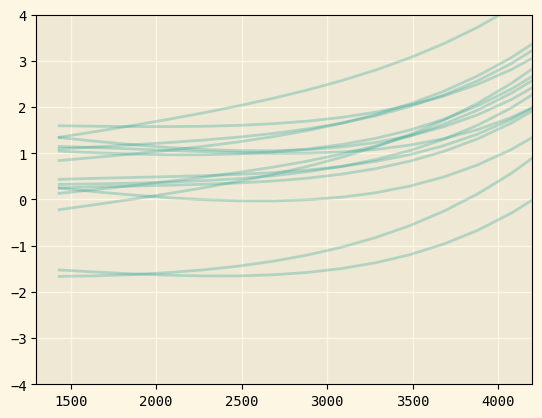

In [308]:

#y_func = gp.sample(jax.random.PRNGKey(2), shape=(samples,))
samples = 15

gp_samples = gp.sample(jax.random.PRNGKey(np.random.randint(5)), shape=(samples,))

def surf_corr(freqs, nu_max, a, b):
    return freqs + a * ((freqs / nu_max) ** b)

X_tiled = np.tile(X,(samples,1))


nn_freqs = np.tile(gp_df[[f"nu_0_{i}" for i in range(6, 41)]].iloc[0].values.flatten(),(samples,1))


plt.plot(X_tiled.T, gp_samples.T+(nn_freqs.T - surf_corr(nn_freqs.T, gp_df['nu_max'].iloc[0], -5, 5)), c='C1', alpha=0.3);
plt.xlim(1300, 4200)
plt.ylim(-4,4)

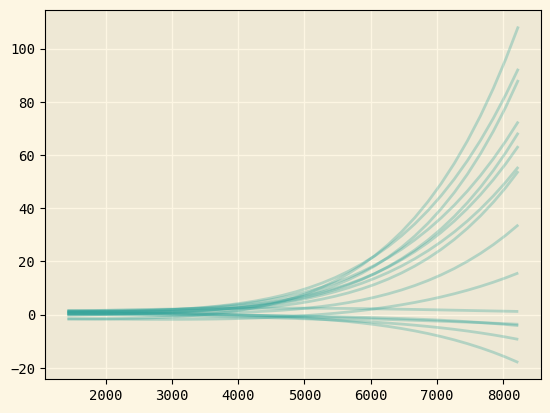

In [322]:

#y_func = gp.sample(jax.random.PRNGKey(2), shape=(samples,))
samples = 15

gp_samples = gp.sample(jax.random.PRNGKey(np.random.randint(5)), shape=(samples,))

def surf_corr(freqs, nu_max, a, b):
    return - a * ((freqs / nu_max) ** b)

X_tiled = np.tile(X,(samples,1))


nn_freqs = np.tile(gp_df[[f"nu_0_{i}" for i in range(6, 41)]].iloc[0].values.flatten(),(samples,1))


plt.plot(X_tiled.T, gp_samples.T + surf_corr(nn_freqs.T, gp_df['nu_max'].iloc[0], np.random.uniform(-10,2,samples), np.random.uniform(4.4,5.25,samples)), c='C1', alpha=0.3);
#plt.xlim(1300, 5000)
#plt.ylim(-4,4)

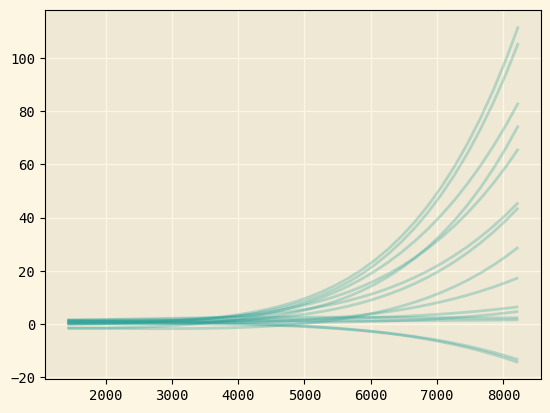

In [285]:

#y_func = gp.sample(jax.random.PRNGKey(2), shape=(samples,))
samples = 15

gp_samples = gp.sample(jax.random.PRNGKey(np.random.randint(5)), shape=(samples,))

def surf_corr(freqs, nu_max, a, b):
    return freqs + a * ((freqs / nu_max) ** b)

X_tiled = np.tile(X,(samples,1))


nn_freqs = np.tile(gp_df[[f"nu_0_{i}" for i in range(6, 41)]].iloc[0].values.flatten(),(samples,1))


plt.plot(X_tiled.T, gp_samples.T+(nn_freqs.T - surf_corr(nn_freqs.T, gp_df['nu_max'].iloc[0], np.random.uniform(-10,2,samples), np.random.uniform(4.4,5.25,samples))), c='C1', alpha=0.3);
#plt.xlim(, 4200)
#plt.ylim(-4,4)

array([-13163.21036636,  -9867.74772962])

## Inference

In [303]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


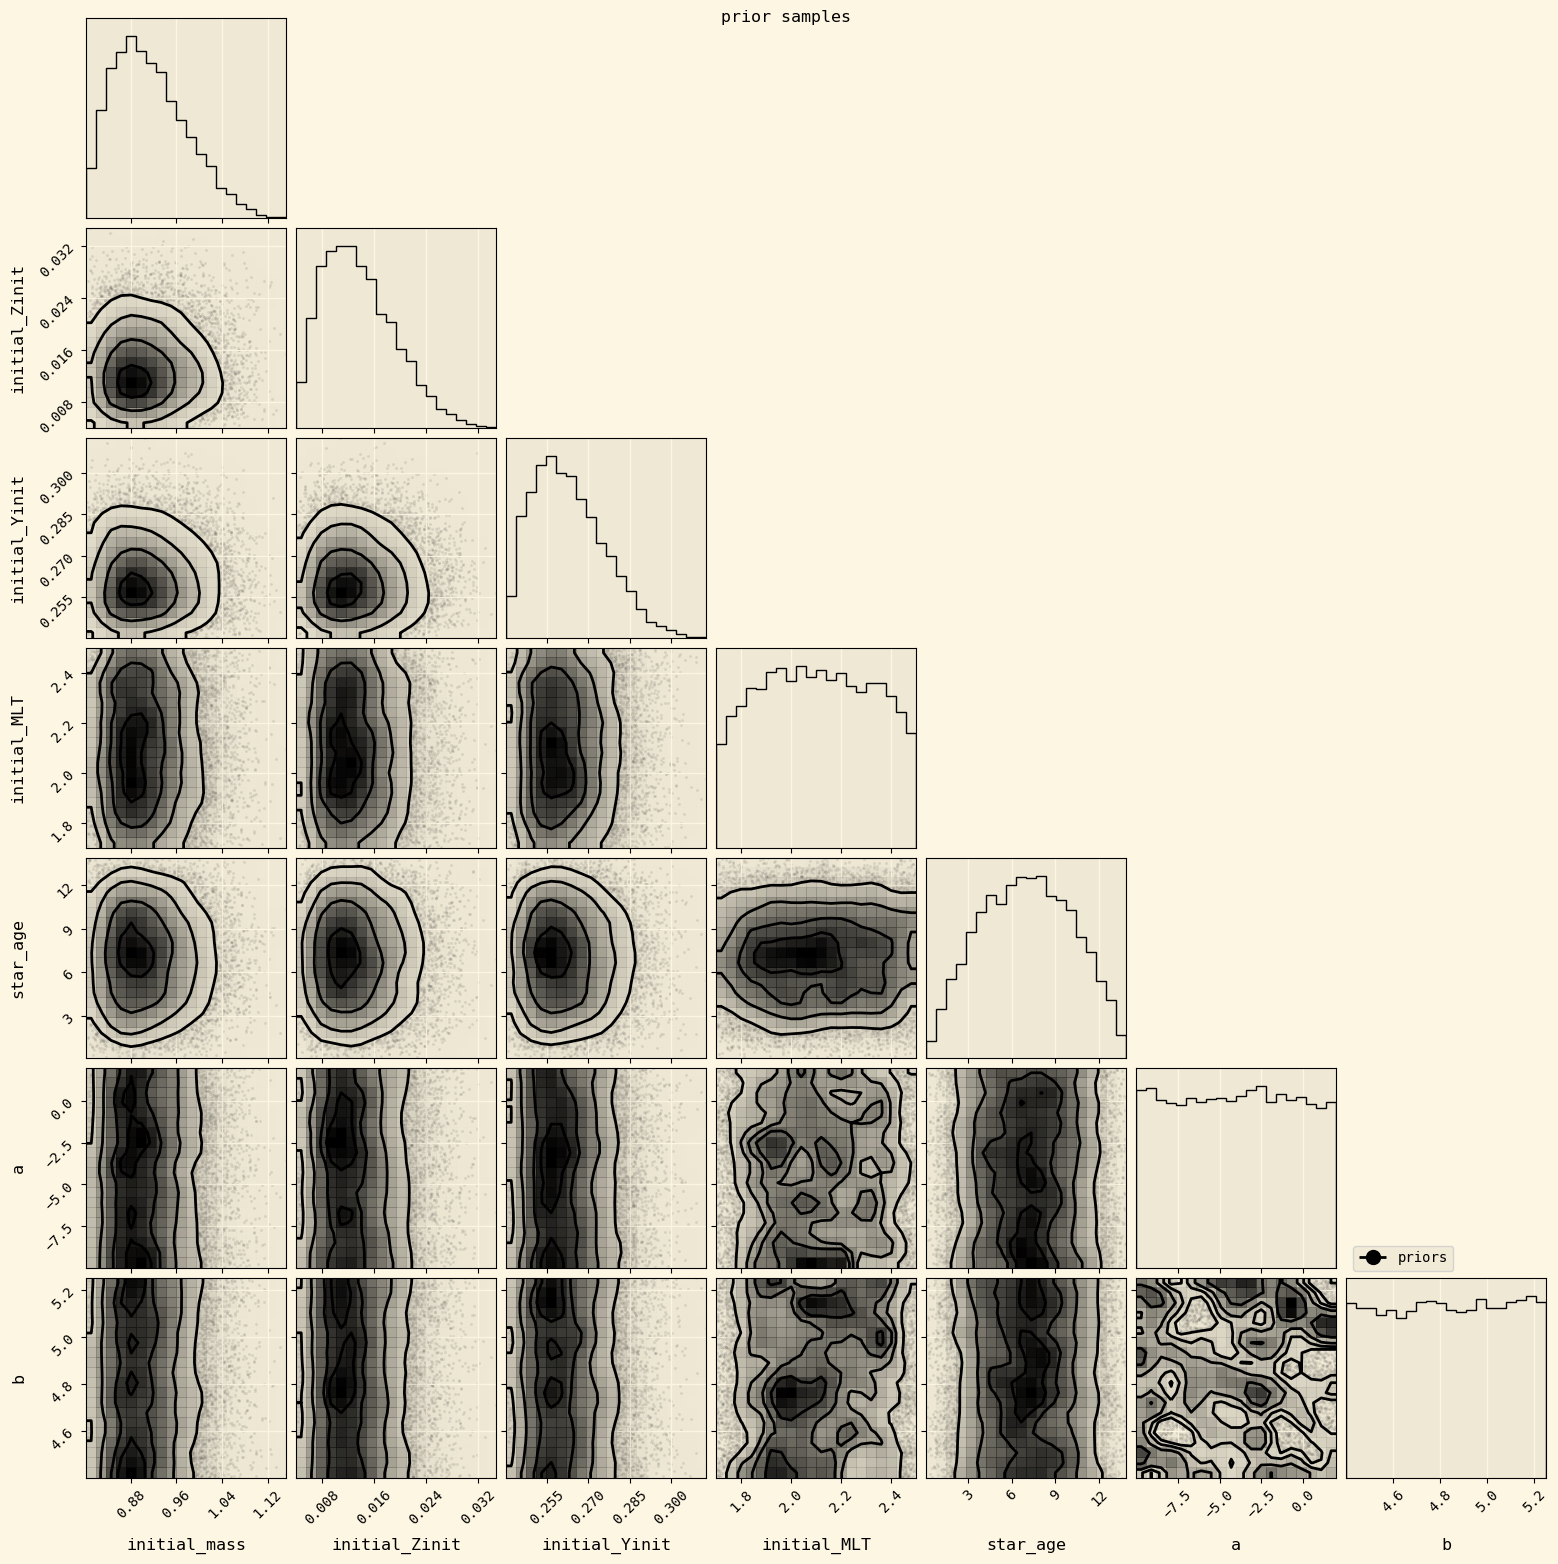

In [304]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [305]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)
    
ndraw_min=128
ndraw_max=4096

for obs_idx in range(1):
    for hare_idx in range(1):
        path = f'surf_form/hare{hare_idx}/obs{obs_idx}/'

        hare_df = pd.read_json(f"surf_form/hare{hare_idx}/hare{hare_idx}.json")
        nu_max = hare_df["nu_max"].values[0]
        
        hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
        hare_uncs = pd.read_json(path+'uncs.json')
        hare_uncs_array = hare_uncs.values[0]
    
        n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
        n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))
    
        sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
        sigma_nn_mask[:3] = True
        sigma_nn_mask[n_min-3:n_max-2] = True
    
        sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]
    
        sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))
    
        sigma = sigma_nn_cropped + sigma_obs
    
        sigma_inv = np.linalg.inv(sigma)
    
        _, log_sigma_det = np.linalg.slogdet(sigma)
        
        outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
        
        sampler = ultra_ns_vector_surface(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
        results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=64, frac_remain=.1)
        with open(path+'/samples.pkl', 'wb') as fp:
            pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
        sampler.cleanup()
        del results

[ultranest] Sampling 64 live points from prior ...


KeyboardInterrupt: 